In [19]:
import rasterio
import json
import numpy as np
from rasterio.vrt import WarpedVRT
import boto3
import re
from matplotlib import pyplot as plt
import dateutil.parser
# need to modify satsearch to point to the development STAC api.
from satsearch.search import Query

In [20]:
def get_scene_path(scene):
    """
    build the S3 URL for the scene
    :param scene: name of scene
    :return: s3 prefix, Landsat path and row
    """
    if len(scene) == 21:
        path, row = re.match(r'LC8(\d{3})(\d{3})', scene).groups()
        prefix = f'L8/{path}/{row}/{scene}'
    else:
        path, row = re.match(r'LC08_L1TP_(\d{3})(\d{3})', scene).groups()
        prefix = f'c1/L8/{path}/{row}/{scene}'

    return prefix, path, row

In [21]:
def calculate_temperature(arr, prefix, scene):
    """
    Caclulate LST from DN
    :param arr: array of raw DN values
    :param prefix:landsat scene prefix
    :param scene: landsat scene id
    :return: array in Celsius
    """
    client = boto3.client("s3")
    result = client.get_object(Bucket='landsat-pds', Key=f'{prefix}/{scene[0]}_MTL.json')
    landsat_metadata = json.loads(result["Body"].read())

    RADIANCE_MULT_BAND_10 = landsat_metadata['L1_METADATA_FILE']['RADIOMETRIC_RESCALING']['RADIANCE_MULT_BAND_10']
    RADIANCE_ADD_BAND_10 = landsat_metadata['L1_METADATA_FILE']['RADIOMETRIC_RESCALING']['RADIANCE_ADD_BAND_11']
    K1_CONSTANT_BAND_10 = landsat_metadata['L1_METADATA_FILE']['TIRS_THERMAL_CONSTANTS']['K1_CONSTANT_BAND_10']
    K2_CONSTANT_BAND_10 = landsat_metadata['L1_METADATA_FILE']['TIRS_THERMAL_CONSTANTS']['K2_CONSTANT_BAND_10']

    toa_arr = RADIANCE_MULT_BAND_10*arr[0] + RADIANCE_ADD_BAND_10

    # output is Kelvin
    asb_arr_k = (K2_CONSTANT_BAND_10/np.log((K1_CONSTANT_BAND_10/toa_arr)+1))
    # convert to celsius
    asb_arr_c = asb_arr_k-237.15

    return asb_arr_c

In [22]:
def get_image(scene):
    """
    Fetch and process a scene
    :param scene: scene param
    :return: array
    """
    prefix, path, row = get_scene_path(scene[0])

    with rasterio.open(f's3://landsat-pds/{prefix}/{scene[0]}_B{band}.TIF') as src:
        with WarpedVRT(src, crs='epsg:3857') as vrt:
            # bounding box of grounds, roughly
            bounds = stampede_bbox
            window = vrt.window(*bounds)
            arr_transform = vrt.window_transform(window)
            profile = vrt.profile
            arr = vrt.read(window=window)

    arr_c = calculate_temperature(arr, prefix, scene)
    return arr_c

In [23]:
def save_output(array, profile, scene):
    """
    Save the array to a Tiff
    :param array: input array
    :param profile: rasterio profile
    :return: null
    """

    profile.update(
        driver='GTiff',
        dtype=rasterio.float32,
        count=1,
        compress='lzw',
    )
    with rasterio.open(f'Stampede_{dateutil.parser.parse(scene[1]).date()}.tif', 'w', **profile) as dst:
        dst.write(array.astype(rasterio.float32), 1, window=window)

    print(f'File written to Stampede_{dateutil.parser.parse(scene[1]).date()}.tif')

In [29]:
stampede_bounds = '{ "type": "Feature", "properties": { }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -114.059555453335022, 51.030873392538702 ], [ -114.059015377397131, 51.038209350996318 ], [ -114.048159851045426, 51.038141430781749 ], [ -114.048159851045426, 51.030567702400148 ], [ -114.059555453335022, 51.030873392538702 ] ] ] } }'
stampede_bbox = [-12696971.9910301640629768,6626611.8214358929544687,-12695507.9539398401975632,6628595.635007986798882]
band = 10
search = Query(**{'datetime': '2012-01-01/2018-07-12', 
                  'eo:platform': 'landsat-8',
                  'eo:cloud_cover': '0/50',
                  'limit': '200',
                  'page': '1',
                  'intersects': stampede_bounds
                 })
search.query()
# This will error out. Fine for now.

KeyError: 'meta'

In [30]:
stac_results = search.results
scenes =[{'date': feature['properties']['datetime'],
          'id': re.search(r'(LC8\w{18})|(LC08_L1TP_\w{30})',
                          feature['assets'][f'B{band}']['href']).group()} for feature in stac_results['features']]

In [31]:
stampede_ids = []
for i,j in enumerate(scenes):
    if dateutil.parser.parse(scenes[i]['date']).month == 7:
        stampede_ids.append([scenes[i]['id'],scenes[i]['date']])
print(f"Found {stac_results['properties']['found']} scenes")
print(f"Found {len(stampede_ids)} scenes within the timeframe selected")

Found 159 scenes
Found 12 scenes within the timeframe selected


In [32]:
stampede_ids.sort(key=lambda x: x[1])
individual_scene = stampede_ids[5]
arr_c = get_image(individual_scene)

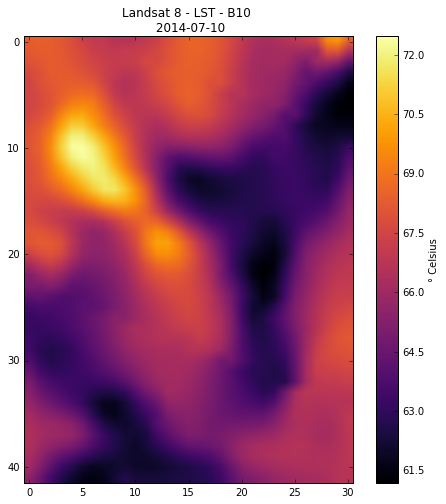

In [33]:
plt.figure(figsize=(8 ,8))
plt.imshow(arr_c, cmap="inferno")
plt.colorbar(label='° Celsius')
plt.title(f"Landsat 8 - LST - B{band} \n {dateutil.parser.parse(individual_scene[1]).date()}")
plt.show()

Seemingly repeating images, but thats because it is crossing two different images (row/path are different)

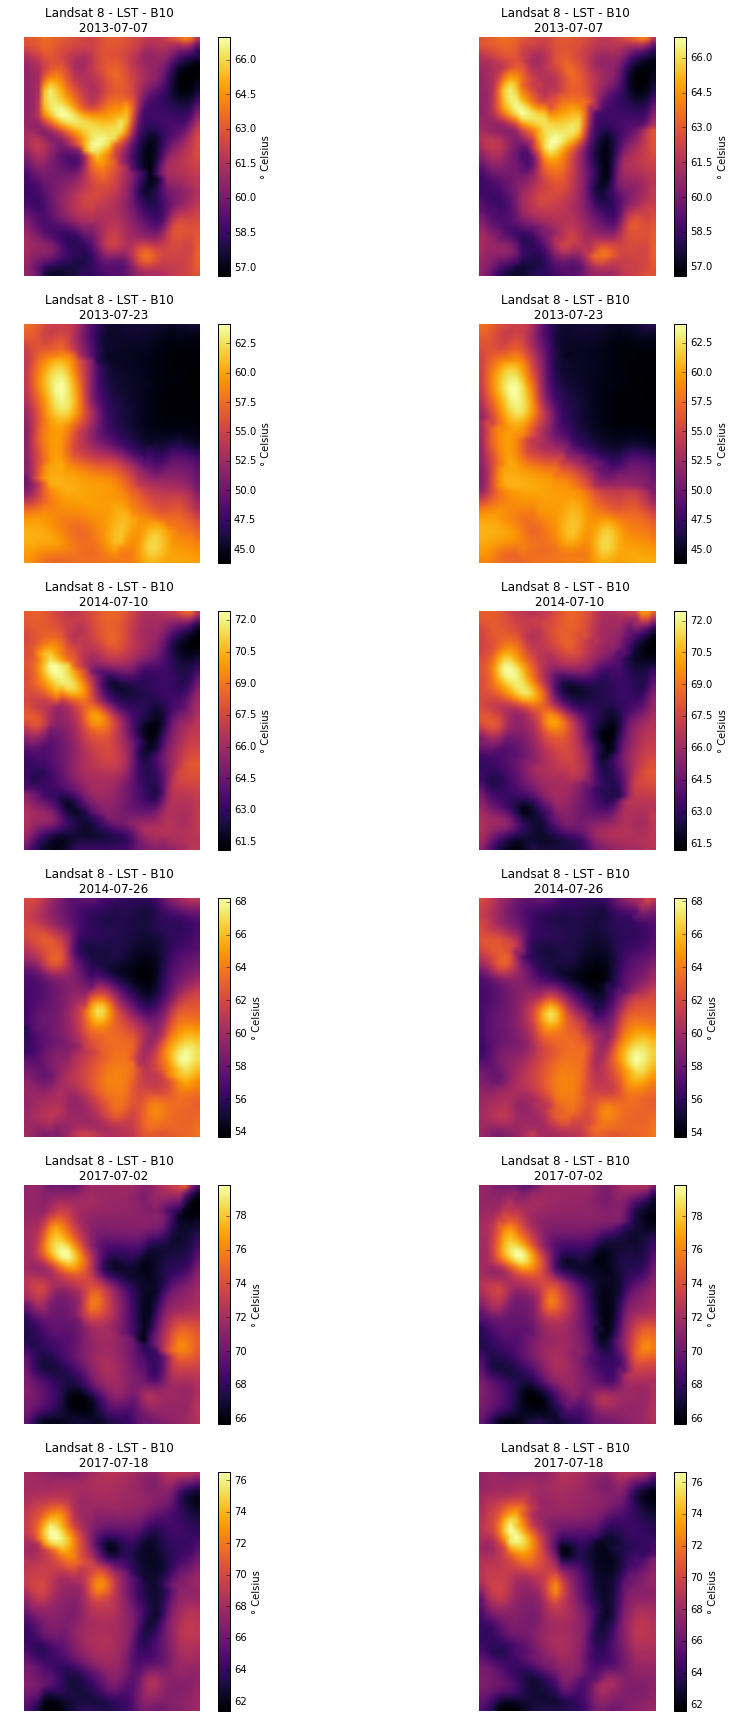

In [34]:
plt.figure(figsize=(15,30))
for idx, scene in enumerate(stampede_ids):
    plt.subplot(6,2,idx+1)
    plt.axis('off')
    plt.imshow(get_image(scene), cmap="inferno")
    plt.colorbar(label='° Celsius')
    plt.title(f"Landsat 8 - LST - B{band} \n {dateutil.parser.parse(scene[1]).date()}")   

plt.show() 